# Лабораторная работа №3
## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей 

## Задание:
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5. Сравните метрики качества исходной и оптимальной моделей.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score 
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold

В качестве датасета выберем набор данных сна за месяц

In [27]:
df = pd.read_csv("Real estate.csv")

In [28]:
#Удаление строк, содержащих пустые значения
df = df.dropna()
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [29]:
df.shape

(414, 8)

<AxesSubplot:>

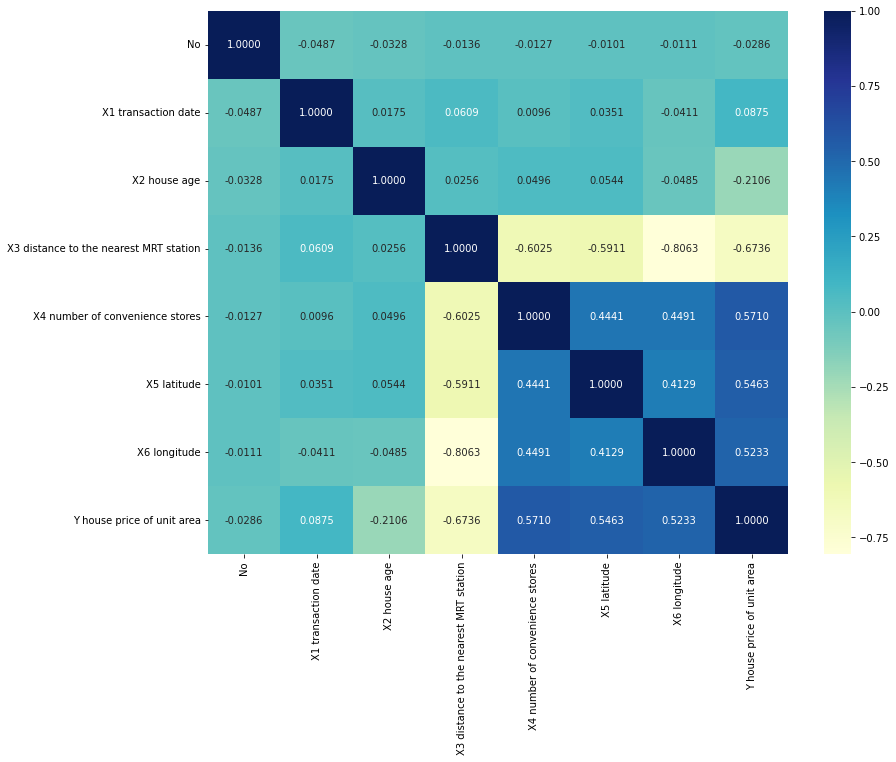

In [30]:
fig, ax = plt.subplots(1,1, figsize=(13,10))
sns.heatmap(df.corr("pearson"), annot=True, fmt=".4f", cmap="YlGnBu")

### Обучающая и тестовая выборка
- В качестве обучающей выборки будем использовать количество лошадиных сил и размер двигателя
- В качестве целевого признака будет выступать цена авто
- Алгоритм KNN будет решать задачу регрессии

In [41]:
myData = pd.DataFrame({"hospital": df["X3 distance to the nearest MRT station"], "shops": df["X4 number of convenience stores"], "price": df["Y house price of unit area"]})
myData

,hospital,shops,price
0,84.87882,10,37.9
1,306.59470,9,42.2
2,561.98450,5,47.3
3,561.98450,5,54.8
4,390.56840,5,43.1
...,...,...,...
409,4082.01500,0,15.4
410,90.45606,9,50.0
411,390.96960,7,40.6
412,104.81010,5,52.5


In [42]:
#С помощью метода train_test_split разделим выборку на обучающую и тестовую
data= myData.drop('price', axis=1)
target= myData['price']
trainX, testX, trainY, testY = train_test_split(data, target, train_size=0.9, random_state=1)

In [43]:
#Обучение модели с гиперпараметром 3
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(trainX, trainY)
pred3_1 = neigh.predict(testX)
pred3_2 = neigh.predict(trainX)
pred3_1 = [i for  i in pred3_1]
pred3_2 = [i for  i in pred3_2]

In [44]:
#Обучение модели с гиперпараметром 10
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(trainX, trainY)
pred10_1 = neigh.predict(testX)
pred10_2 = neigh.predict(trainX)
pred10_1 = [i for  i in pred10_1]
pred10_2 = [i for  i in pred10_2]

## Проверим качество модели с помощью метрик регрессии

### Метрика Root mean squared error (RMSE)

In [48]:
myrmse3_1 = mean_squared_error(testY, pred3_1, squared=False)
myrmse3_2 = mean_squared_error(trainY, pred3_2, squared=False)
print("Для К=3:\t {}\t{}".format(myrmse3_2, myrmse3_1))

Для К=3:	 6.162615641204523	7.223057949204488


In [49]:
myrmse10_1 = mean_squared_error(testY, pred10_1, squared=False)
myrmse10_2 = mean_squared_error(trainY, pred10_2, squared=False)
print("Для К=10:\t {}\t{}".format(myrmse10_2, myrmse10_1))

Для К=10:	 8.066096626308553	5.790600552784207


In [75]:
#Запоминаем результаты
rmse = []
rmse.append(myrmse10_2)
rmse.append(myrmse10_1)

### Коэффициент детерминации

In [76]:
r2_1 = r2_score(testY,pred3_1)
r2_2 = r2_score(trainY,pred3_2)
print("Для К=3:\t {}\t{}".format(r2_1, r2_2))

Для К=3:	 0.6767396019014553	0.7954861044469397


In [77]:
r2_1 = r2_score(testY,pred10_1)
r2_2 = r2_score(trainY,pred10_2)
print("Для К=10:\t {}\t{}".format(r2_1, r2_2))

Для К=10:	 0.7922421127912898	0.6496359822342916


## Подбор гиперпараметра с помощью кросс-валидации
Найдём наилучший гиперпараметр используя текущую перестановку

KFold()

In [78]:
kf = KFold(n_splits=10)
r = np.array(range(1,50))
params = [{"n_neighbors": r}]
gs= GridSearchCV(KNeighborsRegressor(), params, cv=kf, scoring="r2")
gs.fit(trainX, trainY)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}],
             scoring='r2')

Text(0.5, 1.0, 'Гиперпараметр при KFold()')

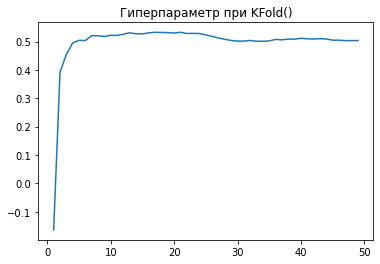

In [79]:
plt.plot(r, gs.cv_results_['mean_test_score'])
plt.title("Гиперпараметр при KFold()")

In [80]:
#Предсказание резульатов на тестовой и обучающей выборках
gs.best_estimator_.fit(trainX, trainY)
predGs1 = gs.best_estimator_.predict(testX)
predGs2 = gs.best_estimator_.predict(trainX)

In [81]:
#Оценка качества с помощью RMSE
rmse.append(mean_squared_error(testY, predGs1, squared=False))
rmse.append(mean_squared_error(trainY, predGs2, squared=False))
(mean_squared_error(testY, predGs1, squared=False), mean_squared_error(trainY, predGs2, squared=False))

(6.376676402612461, 8.451999317087674)

RepeatedKFold()

In [82]:
kf = RepeatedKFold(n_splits=10, n_repeats = 3)
r = np.array(range(1,50))
params = [{"n_neighbors": r}]
gs2= GridSearchCV(KNeighborsRegressor(), params, cv=kf, scoring="r2")
gs2.fit(trainX, trainY)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}],
             scoring='r2')

Text(0.5, 1.0, 'Гиперпараметр при RepeatedKFold()')

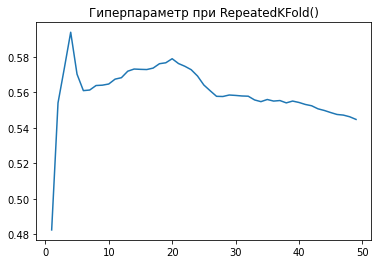

In [83]:
plt.plot(r, gs2.cv_results_['mean_test_score'])
plt.title("Гиперпараметр при RepeatedKFold()")

In [84]:
#Предсказание резульатов на тестовой и обучающей выборках
gs2.best_estimator_.fit(trainX, trainY)
predGs1 = gs2.best_estimator_.predict(testX)
predGs2 = gs2.best_estimator_.predict(trainX)

In [85]:
#Оценка качества с помощью RMSE
rmse.append(mean_squared_error(testY, predGs1, squared=False))
rmse.append(mean_squared_error(trainY, predGs2, squared=False))
(mean_squared_error(testY, predGs1, squared=False), mean_squared_error(trainY, predGs2, squared=False))

(6.907062681122301, 6.755756953601056)

### Сравним метрики качества исходной и оптимальных моделей

In [86]:
X = [i for i in range(len(rmse)//2)]
testRMSE = []
trainRMSE = []
for i in range(len(rmse)):
   if i%2==0:
        trainRMSE.append(rmse[i])
   else:
        testRMSE.append(rmse[i])

<AxesSubplot:title={'center':'Сравнение предсказания тестовой выборки'}, xlabel='Marks', ylabel='RMSE'>

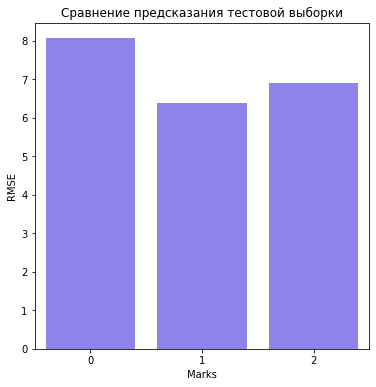

In [87]:
dataframe = pd.DataFrame({"Marks": X, "RMSE": trainRMSE})
fig, ax = plt.subplots(figsize=(6,6)) 
ax.title.set_text("Сравнение предсказания тестовой выборки")
sns.barplot(data=dataframe, y="RMSE", x="Marks", color="#8172fb")

<AxesSubplot:title={'center':'Сравнение предсказания обучающей выборки'}, xlabel='Marks', ylabel='RMSE'>

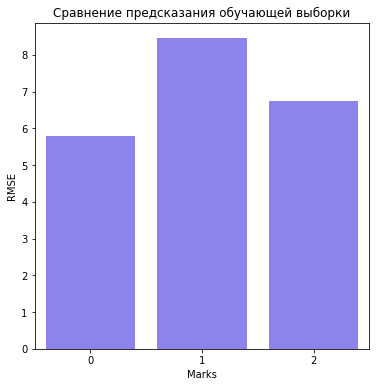

In [88]:
dataframe = pd.DataFrame({"Marks": X, "RMSE": testRMSE})
fig, ax = plt.subplots(figsize=(6,6)) 
ax.title.set_text("Сравнение предсказания обучающей выборки")
sns.barplot(data=dataframe, y="RMSE", x="Marks", color="#8172fb")